In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import cheatcodes as cc

In [2]:
# import numpy as np

# Read the txt file
with open('Cuddapah.txt', 'r') as file:
    lines = file.readlines()

# Extract longitude, latitude, and depth from each line
longitude = []
latitude = []
depth = []
for line in lines:
    values = re.split(r'\s+', line.strip())  # Split using one or more whitespace characters
    longitude.append(float(values[0]))
    latitude.append(float(values[1]))
    depth.append(float(values[2]))

# Convert lists to numpy arrays
longitude = np.array(longitude)
latitude = np.array(latitude)
depth = np.array(depth)

# Determine unique longitude and latitude values
unique_longitude = np.unique(longitude)
unique_latitude = np.unique(latitude)

# Construct 2D matrix with depth values
num_longitude = len(unique_longitude)
num_latitude = len(unique_latitude)
depth_matrix = np.zeros((num_latitude, num_longitude))

# Fill the depth matrix
for i in range(len(depth)):
    lon_index = np.where(unique_longitude == longitude[i])[0][0]
    lat_index = np.where(unique_latitude == latitude[i])[0][0]
    depth_matrix[lat_index][lon_index] = depth[i]

# Now you have depth_matrix, unique_latitude, and unique_longitude
print("Depth Matrix:")
print(depth_matrix)
print("\nLatitude Array:")
print(unique_latitude)
print("\nLongitude Array:")
print(unique_longitude)

Depth Matrix:
[[-65.7  -65.38 -63.96 ... -67.72 -74.73 -76.98]
 [-70.22 -70.07 -67.87 ... -67.88 -68.23 -71.61]
 [-71.84 -71.03 -69.7  ... -62.87 -61.88 -64.5 ]
 ...
 [-61.85 -65.51 -68.82 ... -59.35 -56.19 -54.12]
 [-65.65 -69.3  -72.01 ... -59.73 -56.37 -54.74]
 [-68.15 -70.14 -69.77 ... -62.37 -62.37 -57.99]]

Latitude Array:
[13.52083333 13.5625     13.60416667 13.64583333 13.6875     13.72916667
 13.77083333 13.8125     13.85416667 13.89583333 13.9375     13.97916667
 14.02083333 14.0625     14.10416667 14.14583333 14.1875     14.22916667
 14.27083333 14.3125     14.35416667 14.39583333 14.4375     14.47916667
 14.52083333 14.5625     14.60416667 14.64583333 14.6875     14.72916667
 14.77083333 14.8125     14.85416667 14.89583333 14.9375     14.97916667
 15.02083333 15.0625     15.10416667 15.14583333 15.1875     15.22916667
 15.27083333 15.3125     15.35416667 15.39583333 15.4375     15.47916667
 15.52083333 15.5625     15.60416667 15.64583333 15.6875     15.72916667
 15.77083333

In [3]:
print(len(unique_latitude)*len(unique_longitude))

4032


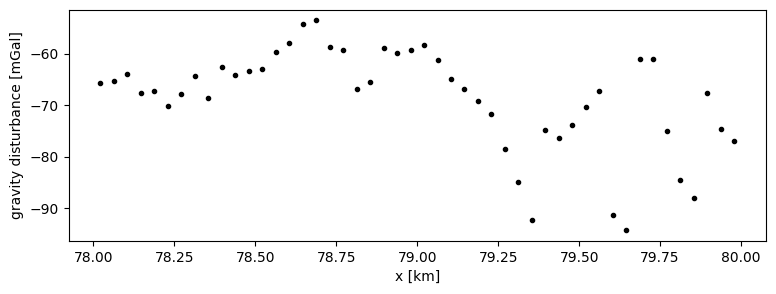

In [4]:
x = unique_longitude
# density = -300  # kg/m³
# data = cc.forward_model(depths, basin_boundaries, density, x)

# noise=np.random.normal(loc=0, scale=1, size=data.size)
# data=data+noise

data=depth_matrix[0][:]

plt.figure(figsize=(9, 3))
plt.plot(x , data, ".k")
plt.xlabel("x [km]")
plt.ylabel("gravity disturbance [mGal]")
plt.show()

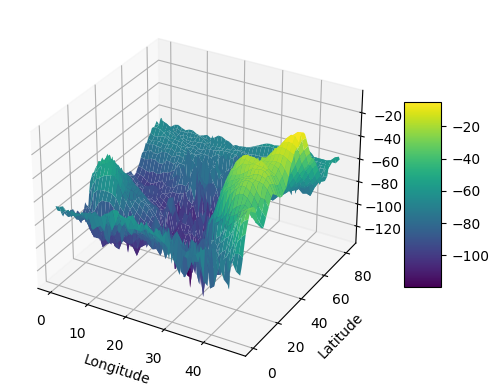

In [5]:
from mpl_toolkits.mplot3d import Axes3D

# Example depth matrix (replace this with your actual depth_matrix)
# depth_matrix = np.random.rand(10, 10)

# Create meshgrid for longitude and latitude
lon_grid, lat_grid = np.meshgrid(range(depth_matrix.shape[1]), range(depth_matrix.shape[0]))

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(lon_grid, lat_grid, depth_matrix, cmap='viridis')

# Add labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth')

# Add color bar
fig.colorbar(surf, shrink=0.5, aspect=5)

# Show plot
plt.show()

In [6]:
basin_boundaries=(77.0,81.0)
density=-300

In [7]:
def make_jacobian(parameters, basin_boundaries, density, x):
    """
    Calculate the Jacobian matrix by finite differences.
    """
    jacobian = np.empty((x.size, parameters.size))
    step = np.zeros_like(parameters)
    delta = 10
    for j in range(jacobian.shape[1]):
        step[j] += delta
        jacobian[:, j] = (
            (
                cc.forward_model(parameters + step, basin_boundaries, density, x)
                - cc.forward_model(parameters, basin_boundaries, density, x)
            ) 
            / delta
        )
        step[j] = 0
    return jacobian

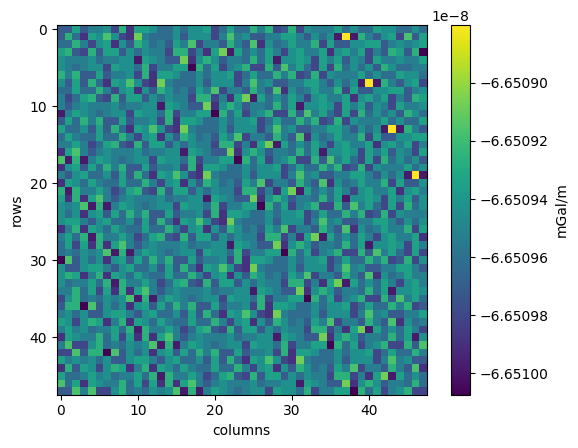

In [8]:
parameters = np.zeros(len(x)) + 5000

jacobian = make_jacobian(parameters, basin_boundaries, density, x)

plt.figure()
plt.imshow(jacobian)
plt.colorbar(label="mGal/m")
plt.xlabel("columns")
plt.ylabel("rows")
plt.show()

In [9]:
def basin2d_inversion(x, data, basin_boundaries, density, initial, max_iterations=10):
    """
    Solve the inverse problem using the Gauss-Newton method.
    """
    parameters = initial.astype(np.float64).copy() 
    predicted = cc.forward_model(parameters, basin_boundaries, density, x)
    residuals =  predicted - data
    goal_function = [np.linalg.norm(residuals)**2]
    for i in range(max_iterations):
        print(i)
        jacobian = make_jacobian(parameters, basin_boundaries, density, x)
        hessian = jacobian.T @ jacobian
        gradient = jacobian.T @ residuals
        deltap = np.linalg.solve(hessian, gradient)
        new_parameters = parameters + deltap
        predicted = cc.forward_model(new_parameters, basin_boundaries, density, x)
        residuals = data - predicted
        current_goal = np.linalg.norm(residuals)**2
#         if current_goal > goal_function[-1]:
#             break
        parameters = new_parameters
        goal_function.append(current_goal)
    return parameters, goal_function

In [10]:
estimated, goal_function = basin2d_inversion(
    x, data, basin_boundaries, density, initial=np.full(10, -40),
)
predicted = cc.forward_model(estimated, basin_boundaries, density, x)
# print(estimated)

0
1


LinAlgError: Singular matrix

In [ ]:
plt.figure(figsize=(9, 3))
plt.plot(x / 1e3, data, ".k", label="observed")
plt.plot(x / 1e3, predicted, "-r", label='predicted')
plt.legend()
plt.xlabel("x [km]")
plt.ylabel("gravity disturbance [mGal]")
plt.show()

In [ ]:
plt.figure()
plt.plot(goal_function)
plt.yscale("log")
plt.xlabel("iteration")
plt.ylabel("goal function (mGal²)")
plt.show()